# Lab. \#1. Feature Extraction and Machine Learning
By Nurtdinov Damir.

*Jan, 21, 2025.*

## Problem Statement

The lab compares two approaches to machine learning (ML) and computer vision (CV). The *first approach* involves using an ML model for both automatic feature extraction and subsequent classification. The *second approach* processes hand-designed features, such as geometric features of objects in images, with an ML classification model. Historically, the second approach preceded the first. However, in modern coding, the first approach is easier to implement. Thus, this work is organized in order of increasing model complexity.

The **main problem** addressed in this work is determining the better approach. The choice may not be straightforward, as many modern competitions related to CV problems, such as those submitted on [Kaggle](https://www.kaggle.com/competitions), often use a hybrid trick: instead of solving a CV problem directly with an image-processing model (e.g., a convolutional neural network or a visual transformer), the best solutions are often based on preliminary feature extraction followed by the analysis of tabular data using models like gradient boosting.

The **dataset** used in this work is the MNIST database, consisting of $28\times28$ pixel images of handwritten digits, with a training subset of 60,000 examples and a test subset of 10,000 examples.

The *first approach* can be implemented with a simple multi-layer perceptron (MLP) model to solve a multi-class classification problem by minimizing the cross-entropy (CE) loss, as described in [Prince, 2024](https://udlbook.github.io/udlbook/).

The *second approach* can also be implemented using the same network architecture and loss function but with a modified dataset. In this case, the image dataset is replaced with a tabular dataset of hand-designed features. These features can be extracted using standard tools in [Scikit-learn](https://scikit-learn.org/1.5/modules/feature_extraction.html) or [OpenCV](https://docs.opencv.org/3.4/d0/d49/tutorial_moments.html).

## Tasks and Requirements  

- Fill in your name and date information above.  
- Review the [Lightning framework](https://lightning.ai/docs/pytorch/stable/) (Level Up, Core API, Optional API sections of the manual).  
- Briefly review the [ClearML](https://clear.ml/docs/latest/docs/integrations/pytorch_lightning/) documentation.  
- Run the code below cell by cell and replace the placeholder text "Enter your code here" with your implementation in the missing code fragments.  
- If the code works properly, implement five parallel tests. Otherwise, fix the code before proceeding.  
- Fill in the table, add figures in the Results section, and complete the Conclusion section of the lab.  
- Address the Questions section and prepare to defend the lab.  

### Bonus (complete one of the following as a bonus task):  
- Apply a t-SNE model to visualize both the original image dataset and the table dataset with hand-extracted features.  
- Add one or more features in the `TabularDataModule` to enhance the tabular model's capability.  
- Visualize the feature extraction process implemented in the `extract_features` function using one or more samples.  
- Apply a gradient boosting model to solve the table data classification problem in the second approach. Fine-tune both models to improve accuracy.  

### A List of Blocks with Missing Code  
- Preparation of simulation models/Set the model/Logging
- Approach #2: Hand-designed feature extraction followed by tabular data classification using the ANN.  
- Results and Discussion.  
- Conclusion.

# Preparation of simulation models

## Import and Install Libraries

In [1]:
!pip install pytorch-lightning clearml

In [2]:
#Pytorch modules
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
#Numpy
import numpy as np
#Pandas
import pandas as pd
#Lightning & logging
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
#Image processing (OpenCV)
import cv2
#Data observation
import os
from pathlib import Path
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Logging
from clearml import Task

## Set the Models

### Simulation Settings

Check the current directory

In [3]:
os.getcwd() #returns the current working directory

'/content'

In [4]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/")
print(f'CHECKPOINT_PATH: {CHECKPOINT_PATH}')

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

CHECKPOINT_PATH: saved_models/


Set the reproducibility options

In [5]:
# Function for setting the seed to implement parallel tests
SEED = 3 # random seeds are 42, 0, 17, 9, 3
pl.seed_everything(SEED)

# # Ensure that all operations are deterministic on GPU (if used) for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

# torch.manual_seed(SEED)
# np.random.seed(SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 3


3

### Logging

To configure ClearML in your Colab environment, follow these steps:

---

*Step 1: Create a ClearML Account*
1. Go to the [ClearML website](https://clear.ml/).
2. Sign up for a free account if you don’t already have one.
3. Once registered, log in to your ClearML account.

---

*Step 2: Get Your ClearML Credentials*
1. After logging in, navigate to the **Settings** page (click on your profile icon in the top-right corner and select **Settings**).
2. Under the **Workspace** section, find your **+ Create new credentials**.
3. Copy these credentials for a Jupiter notebook into the code cell below.

---

*Step 3: Accessing the ClearML Dashboard*
1. Go to your ClearML dashboard (https://app.clear.ml).
2. Navigate to the **Projects** section to see your experiments.
3. Click on the experiment (e.g., `Lab_1`) to view detailed metrics, logs, and artifacts.

---

In [6]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=9IZOY1DFTOA4EKJ756F0IQD2K6VJ0V
%env CLEARML_API_SECRET_KEY=j8gnmAJdmA03ZO9rTkKYzo1EN-2vWGmcy6xx185ndCR5PwY36RbSS_LQLJz-Sn7OGho

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=9IZOY1DFTOA4EKJ756F0IQD2K6VJ0V
env: CLEARML_API_SECRET_KEY=j8gnmAJdmA03ZO9rTkKYzo1EN-2vWGmcy6xx185ndCR5PwY36RbSS_LQLJz-Sn7OGho


In [7]:
task = Task.init(project_name="CV-2025", task_name=f'Lab_1_seed={SEED}_img')
print("ClearML is configured correctly!") #just to make you feel better

ClearML Task: created new task id=dfb96509347043edac33a796fd594553
2025-01-21 18:14:25,871 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/edae844b1820483eb0d3e3030b2a943d/experiments/dfb96509347043edac33a796fd594553/output/log
ClearML is configured correctly!


### Dataset

Summary

In [8]:
DATASET = 'MNIST'
NS = {
    'train': 55000,
    'val': 5000,
    'test': 10000
} # for MNIST

SIZE = 28 #image size
NUM_CLASSES = 10
CLASS_NAMES = ['zero' ,'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

Normalization parameters

In [9]:
#For the MNIST dataset
MEAN = np.array([0.1307])
STD  = np.array([0.3081])

Transforms

### Collect parameters

In [10]:
#Model parameters
LOSS_FUN = 'CE' # 'CE', etc.
ARCHITECTURE = 'MLP' # 'MLP', etc.

#Collect the parameters (hyperparams and others)
hparams = {
    "seed": SEED,
    "lr": 0.0001,
    'weight_decay': 0.0,
    "dropout": 0.0,
    "bs": 64,
    "num_workers": 2,
    "num_epochs": 5,
    "criterion": LOSS_FUN,
    "num_samples": NS,
    "im_size": SIZE,
    "mean": MEAN,
    "std": STD,
    "n_classes": 10,
}
#Visualization
vis_params = {
    'fig_size': 5,
    'num_samples': 5,
    'num_bins': 50,
}

## Functions

### Lightning

Data module

In [11]:
# Approach #1: dataset of images
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, params):
        super().__init__()
        self.seed = params['seed']
        self.batch_size = params['bs']
        self.num_workers = params['num_workers']
        self.mean = params['mean']
        self.std =  params['std']
        self.ns = params['num_samples']
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def prepare_data(self):
        # Download MNIST dataset
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        mnist_full = datasets.MNIST(root='./data', train=True,
                                    transform=self.transform)
        pl.seed_everything(self.seed)
        self.mnist_train, self.mnist_val = random_split(mnist_full,
                                                        [self.ns['train'],
                                                         self.ns['val']])
        self.mnist_test = datasets.MNIST(root='./data', train=False,
                                         transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size,
                          num_workers=self.num_workers,)
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size,
                          shuffle=False)

# Approach #2: tabular dataset of extracted features
class TabularDataModule(MNISTDataModule):
    def __init__(self, params):
        super().__init__(params)
        self.feature_names = [
            'mean_intensity', 'std_intensity', 'num_edges',
            'aspect_ratio', 'cx', 'cy', 'num_contours', 'area',
            'perimeter', 'inertia', 'compactness', 'eccentricity'
        ]
        self.scaler = StandardScaler()  # Initialize the StandardScaler

    def setup(self, stage=None):
        # Call the parent class's setup method to load and split the MNIST dataset
        super().setup(stage)

        # Extract features from the MNIST datasets
        self.train_features, self.train_labels = self._extract_features(self.mnist_train)
        self.val_features, self.val_labels = self._extract_features(self.mnist_val)
        self.test_features, self.test_labels = self._extract_features(self.mnist_test)

        # Normalize the features using StandardScaler
        self.scaler.fit(self.train_features)  # Fit the scaler on the training data
        self.train_features = self.scaler.transform(self.train_features)
        self.val_features = self.scaler.transform(self.val_features)
        self.test_features = self.scaler.transform(self.test_features)

    def _extract_features(self, dataset):
        """
        Extract features from a dataset of MNIST images.
        :param dataset: A PyTorch dataset of MNIST images.
        :return: A tuple (features, labels) where features is a NumPy array and labels is a NumPy array.
        """
        features = []
        labels = []
        for image, label in dataset:
            # Convert image to numpy array
            image_np = image.squeeze().numpy()

            # Extract features
            feature_vector = extract_features(image_np)
            features.append(feature_vector)
            labels.append(label)

        return np.array(features), np.array(labels)

    def train_dataloader(self):
        # Create a TensorDataset from features and labels
        train_dataset = TensorDataset(
            torch.tensor(self.train_features, dtype=torch.float32),
            torch.tensor(self.train_labels, dtype=torch.long)
        )
        return DataLoader(train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        # Create a TensorDataset from features and labels
        val_dataset = TensorDataset(
            torch.tensor(self.val_features, dtype=torch.float32),
            torch.tensor(self.val_labels, dtype=torch.long)
        )
        return DataLoader(val_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Create a TensorDataset from features and labels
        test_dataset = TensorDataset(
            torch.tensor(self.test_features, dtype=torch.float32),
            torch.tensor(self.test_labels, dtype=torch.long)
        )
        return DataLoader(test_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers)

Training module

In [12]:
class train_model(pl.LightningModule):
    def __init__(self, model=None, losses_dict=None, hparams=hparams):
    # def __init__(self, hparams=hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.model = model
        self.loss_fn = losses_dict[hparams['criterion']]
        self.lr = hparams['lr']
        self.wd = hparams['weight_decay']

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        preds = torch.argmax(h, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'loss': loss, 'preds': preds, 'y': y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr,
                                weight_decay=self.wd)

Callbacks

In [13]:
# Define the ModelCheckpoint callbacks to save the best validation models
#Approach #1
checkpoint_callback_img = ModelCheckpoint(
    monitor='val_loss',       # Monitor validation loss
    dirpath=CHECKPOINT_PATH,  # Directory to save checkpoints
    filename=f'best_model_{ARCHITECTURE}_{SEED}_img',# Checkpoint filename
    save_top_k=1,             # Save only the best model
    mode='min',               # Minimize validation loss
)
#Approach #2
checkpoint_callback_tab = ModelCheckpoint(
    monitor='val_loss',       # Monitor validation loss
    dirpath=CHECKPOINT_PATH,  # Directory to save checkpoints
    filename=f'best_model_{ARCHITECTURE}_{SEED}_tab',# Checkpoint filename
    save_top_k=1,             # Save only the best model
    mode='min',               # Minimize validation loss
)

### Models

MLP

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size=None, params=hparams):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, params['n_classes'])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, x):
        # Flatten the input if it's an image (shape: [batch_size, 1, im_size, im_size])
        if x.dim() == 4:  # Check if input is an image
            x = x.view(x.size(0), -1)  # Flatten to [batch_size, im_size * im_size]
        elif x.dim() == 2:  # Check if input is tabular data (shape: [batch_size, n_feat])
            pass  # No need to flatten
        else:
            raise ValueError(f"Unexpected input shape: {x.shape}. Expected [batch_size, 1, im_size, im_size] or [batch_size, n_feat].")
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Loss functions

Create a loss function class, or use a standart one.

In [15]:
# Cross entropy loss maden from scratch (just in case)
class CEplus(nn.Module):
    def __init__(self, reduction='mean'):
        super(CEplus, self).__init__()
        self.reduction = reduction

    def forward(self, x, y):
        # Compute softmax probabilities
        prob = nn.functional.softmax(x, 1)
        # Compute log probabilities
        log_prob = -1.0 * torch.log(prob)
        # Gather the log probabilities for the true labels
        loss = log_prob.gather(1, y.unsqueeze(1))
        # Apply reduction
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss.squeeze()  # Remove extra dimension for consistency
        else:
            raise ValueError("Invalid reduction option.")

        return loss

losses_dict = {'CE': nn.CrossEntropyLoss(),
               'CEplus': CEplus(),
}
losses_dict_red = {'CE': nn.CrossEntropyLoss(reduction='none'),
                   'CEplus': CEplus(reduction='none'),
}

### Metrics

In [16]:
def metrics(dataloader,model,loss_fn_red):
    # Collect images, predictions, and losses
    images = []
    preds  = []
    labels = []
    losses = []
    correct= 0
    total  = 0
    for batch in dataloader:
        x, y = batch
        with torch.no_grad():
            h = model(x)
            loss = loss_fn_red(h,y)
            pred = torch.argmax(h, dim=1)
        correct += (pred == y).sum().item()  # Number of correct predictions
        total += y.size(0)  # Total number of samples

        images.extend(x.cpu())
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
        losses.extend(loss.cpu().numpy())
    acc = correct / total
    return images, preds, labels, losses, acc

### Feature extractor

Extracts geometric features of images

In [17]:
def extract_features(image):
    """
    Extract geometric and statistical features from a single MNIST image.
    :param image: A 28x28 numpy array (MNIST image).
    :return: A list of features.
    """
    features = []

    # Normalize the image to [0, 255] for better thresholding
    image = (image * 255).astype(np.uint8)

    # 1. Mean Pixel Intensity
    mean_intensity = np.mean(image)
    features.append(mean_intensity)

    # 2. Standard Deviation of Pixel Intensity
    std_intensity = np.std(image)
    features.append(std_intensity)

    # 3. Number of Edges (using Sobel filter)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobel_x**2 + sobel_y**2)
    num_edges = np.sum(edges > 50)  # Threshold to count edges
    features.append(num_edges)

    # 4. Aspect Ratio
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        x, y, w, h = cv2.boundingRect(contours[0])
        aspect_ratio = float(w) / h if h != 0 else 0
    else:
        aspect_ratio = 0
    features.append(aspect_ratio)

    # 5. Center of Mass
    moments = cv2.moments(image)
    if moments["m00"] != 0:
        cx = moments["m10"] / moments["m00"]
        cy = moments["m01"] / moments["m00"]
    else:
        cx, cy = 0, 0
    features.append(cx)
    features.append(cy)

    # 6. Number of Contours
    num_contours = len(contours)
    features.append(num_contours)

    # 7. Area of the Digit
    if len(contours) > 0:
        area = cv2.contourArea(contours[0])
    else:
        area = 0
    features.append(area)

    # 8. Perimeter Length
    if len(contours) > 0:
        perimeter = cv2.arcLength(contours[0], closed=True)
    else:
        perimeter = 0
    features.append(perimeter)

    # 9. Inertia (Second Moment of Area)
    if len(contours) > 0:
        inertia = moments["mu20"] + moments["mu02"]
    else:
        inertia = 0
    features.append(inertia)

    # 10. Compactness (Perimeter^2 / Area)
    if area > 0:
        compactness = (perimeter ** 2) / area
    else:
        compactness = 0
    features.append(compactness)

    # 11. Eccentricity
    if len(contours) > 0 and len(contours[0]) >= 5:  # Check if contour has at least 5 points
        (_, _), (major_axis, minor_axis), _ = cv2.fitEllipse(contours[0])

        # Ensure minor_axis <= major_axis
        if minor_axis > major_axis:
            major_axis, minor_axis = minor_axis, major_axis

        # Clip the argument of np.sqrt to ensure it is non-negative
        ratio = (minor_axis ** 2) / (major_axis ** 2)
        ratio = np.clip(ratio, 0, 1)  # Clip to [0, 1]

        eccentricity = np.sqrt(1 - ratio)
    else:
        eccentricity = 0
    features.append(eccentricity)

    # Enter your code here to add one or more additional features (bonus track)

    return features

def create_tabular_dataset(dataset):
    """
    Create a tabular dataset from MNIST images by extracting features.
    :param dataset: MNIST dataset (e.g., torchvision.datasets.MNIST).
    :return: A tuple (X, y) where X is the feature matrix and y is the label vector.
    """
    X = []
    y = []

    for image, label in dataset:
        # Convert image to numpy array
        image_np = image.squeeze().numpy()

        # Extract features
        features = extract_features(image_np)
        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

### Visualization

In [18]:
# Plot image samples with top loss values
def top_losses_vis(vis_params, images, preds, labels, losses):
    num_imgs = vis_params['num_samples']
    top_loss_indices = np.argsort(losses)[-num_imgs:]

    plt.figure(figsize=(num_imgs*2, 2))
    for i, idx in enumerate(top_loss_indices):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f'True: {labels[idx]}\nPred: {preds[idx]}\nLoss: {losses[idx]:.2f}')
        plt.axis('off')
    plt.show()

# Plot confusion matrix
def conf_mat(figsize):
    plt.figure(figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Approach \# 1: Feature Extraction and Image Classification Using an ANN

Note: historically, approach #1 is more modern than appooach #2 presented in the next chapter of this notebook.

## Create Dataset and Data Loaders

Initialization of the dataset, the dataloader, and the training module

In [19]:
data_module = MNISTDataModule(hparams)
# Prepare and setup the data
data_module.prepare_data()
data_module.setup()
# Example: Access the training data, check if the feature and labels shapes are correct
train_dataloader = data_module.train_dataloader()
for batch in train_dataloader:
    features, labels = batch
    print("Features shape:", features.shape)  # Should be (batch_size, num_features)
    print("Labels shape:", labels.shape)      # Should be (batch_size,)
    break

INFO:lightning_fabric.utilities.seed:Seed set to 3


Features shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


## Train the Model

Initialize the loss function, and it's version with reduction to calculate loss per image

In [20]:
loss_fn = losses_dict[hparams['criterion']]
loss_fn_red = losses_dict_red[hparams['criterion']]

Initialize the model and the trainer. Log the hyperparameters

In [21]:
pl.seed_everything(SEED) #one more time, just in case
model = train_model(model=MLP(input_size=hparams['im_size']**2), losses_dict=losses_dict)
# Log hyperparameters to ClearML
task.connect(model.hparams)

trainer = Trainer(max_epochs=hparams['num_epochs'],
                  callbacks=[checkpoint_callback_img],
                  accelerator="auto", devices="auto")


INFO:lightning_fabric.utilities.seed:Seed set to 3


2025-01-21 18:14:31,390 - clearml.Task - WARNING - Parameters must be of builtin type (General/mean[ndarray], General/std[ndarray])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [22]:
model

train_model(
  (model): MLP(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (loss_fn): CrossEntropyLoss()
)

Train the model

In [23]:
trainer.fit(model, data_module)

INFO:lightning_fabric.utilities.seed:Seed set to 3
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 109 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Log the best model

In [24]:
best_model_path = checkpoint_callback_img.best_model_path
task.update_output_model(model_path=best_model_path, auto_delete_file=False)

'https://files.clear.ml/CV-2025/Lab_1_seed=3_img.dfb96509347043edac33a796fd594553/models/best_model_MLP_3_img-v1.ckpt'

## Test the Model

In [25]:
checkpoint_callback_img.best_model_path

'/content/saved_models/best_model_MLP_3_img-v1.ckpt'

Load the best model checkpoint

In [26]:
best_model = train_model.load_from_checkpoint(best_model_path,
                                              model=MLP(input_size=hparams['im_size']**2),
                                              losses_dict=losses_dict)

2025-01-21 18:18:16,188 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/CV-2025/Lab_1_seed%3D3_img.dfb96509347043edac33a796fd594553/models/best_model_MLP_3_img-v1.ckpt


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: UserWarning:

Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.



The Metric and the loss values for the test set (for a batch, probably)

In [27]:
test_results = trainer.test(best_model, datamodule=data_module)
print(test_results)

INFO:lightning_fabric.utilities.seed:Seed set to 3


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9521999955177307     │
│         test_loss         │    0.16589398682117462    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16589398682117462, 'test_acc': 0.9521999955177307}]


The metrics for the entire test set

In [28]:
test_images, test_preds, test_labels, test_losses, test_acc =  metrics(data_module.test_dataloader(),
                                                             best_model, loss_fn_red)
print(f'Accuracy for the entire test set is: {test_acc}')
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

Accuracy for the entire test set is: 0.9522


Visualize the test results

With the confusion matrix for the test set

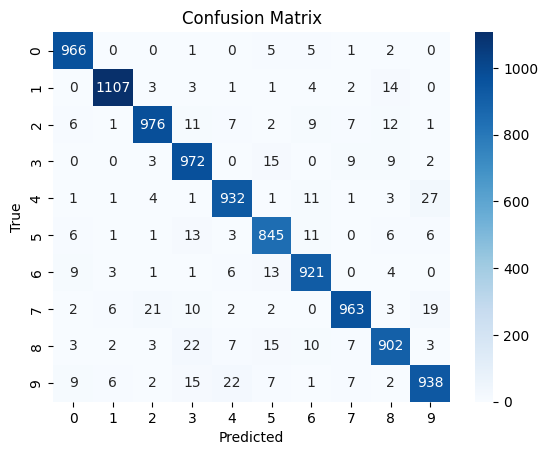

In [29]:
conf_mat(vis_params['fig_size'])

With the test samples of top losses

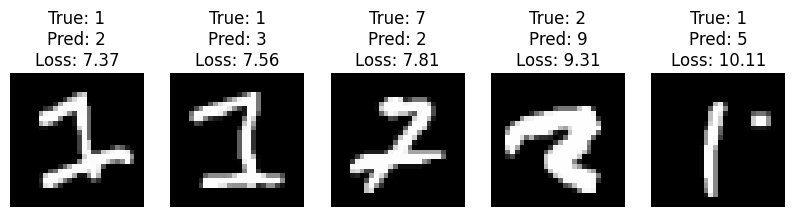

In [30]:
top_losses_vis(vis_params, test_images, test_preds, test_labels, test_losses)

Clear some memory and stop logging the task

In [31]:
del data_module, model, trainer, best_model, test_images, test_preds, test_labels, test_losses
task.close()

# Approach \# 2: Hand-Designed Feature Extraction and the Following Tabular Data Classification using the ANN

## Start Tracking a New Task

In [32]:
# Enter your code here to create a new task entiteled f'Lab_1_seed={SEED}_tab'
#in the same project
task = Task.init(project_name="CV-2025", task_name=f'Lab_1_seed={SEED}_tab')
print("ClearML is configured correctly!") #just to make you feel better

ClearML Task: created new task id=981d79417e06435ea00887bc98d7d769
ClearML results page: https://app.clear.ml/projects/edae844b1820483eb0d3e3030b2a943d/experiments/981d79417e06435ea00887bc98d7d769/output/log
ClearML is configured correctly!


## Create Dataset and Data Loaders

In [33]:
# Enter your code here to:
# Initialize the TabularDataModule
# data_module = ...
data_module = TabularDataModule(hparams)

# Prepare and setup the data
data_module.prepare_data()
data_module.setup()

# Example: Access the training data, check if the feature and labels shapes are correct
train_dataloader = data_module.train_dataloader()
for batch in train_dataloader:
    features, labels = batch
    print("Features shape:", features.shape)  # Should be (batch_size, num_features)
    print("Labels shape:", labels.shape)      # Should be (batch_size,)
    break

INFO:lightning_fabric.utilities.seed:Seed set to 3


Features shape: torch.Size([64, 12])
Labels shape: torch.Size([64])


## Train the Model

Initialization of the dataset, the dataloader, and the training module

In [34]:
pl.seed_everything(SEED) #just in case
#Enter your code here to create the model
#model = ...
model = train_model(model=MLP(input_size=features.shape[1]), losses_dict=losses_dict)
# Log hyperparameters to ClearML
task.connect(model.hparams)
# Start the trainer with appropriate callbacks
# trainer = Trainer(max_epochs=...,
                  # callbacks=...,
                  # accelerator="auto", devices="auto")
trainer = Trainer(max_epochs=hparams['num_epochs'],
                  callbacks=[checkpoint_callback_tab],
                  accelerator="auto", devices="auto")


INFO:lightning_fabric.utilities.seed:Seed set to 3
Parameters must be of builtin type (General/mean[ndarray], General/std[ndarray])
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [35]:
#Check if the model looks fine
model

train_model(
  (model): MLP(
    (fc1): Linear(in_features=12, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (loss_fn): CrossEntropyLoss()
)

Train the model

In [36]:
trainer.fit(model, data_module)

INFO:lightning_fabric.utilities.seed:Seed set to 3
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 10.6 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Log the best model

In [37]:
# Enter your code here to define the best model path
# best_model_path =
best_model_path = checkpoint_callback_tab.best_model_path
task.update_output_model(model_path=best_model_path, auto_delete_file=False)

'https://files.clear.ml/CV-2025/Lab_1_seed=3_tab.981d79417e06435ea00887bc98d7d769/models/best_model_MLP_3_tab-v1.ckpt'

## Test the Model

In [38]:
checkpoint_callback_tab.best_model_path

'/content/saved_models/best_model_MLP_3_tab-v1.ckpt'

In [39]:
best_model_path

'/content/saved_models/best_model_MLP_3_tab-v1.ckpt'

Load the best model checkpoint

In [40]:
# Enter your code here to load the best model from the checkpoint usine features.shape[-1] as the input size
# best_model =
best_model = train_model.load_from_checkpoint(best_model_path,
                                              model=MLP(input_size=features.shape[1]),
                                              losses_dict=losses_dict)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: UserWarning:

Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.



The Metric and the loss values for the test set (for a batch, probably)

In [41]:
test_results = trainer.test(best_model, datamodule=data_module)
print(test_results)

INFO:lightning_fabric.utilities.seed:Seed set to 3


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3384000062942505     │
│         test_loss         │    1.7634987831115723     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7634987831115723, 'test_acc': 0.3384000062942505}]


The metrics for the entire test set

In [42]:
test_images, test_preds, test_labels, test_losses, test_acc =  metrics(data_module.test_dataloader(),
                                                             best_model, loss_fn_red)
print(f'Accuracy for the entire test set is: {test_acc}')
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

Accuracy for the entire test set is: 0.3384


Visualize the test results

With the confusion matrix for the test set

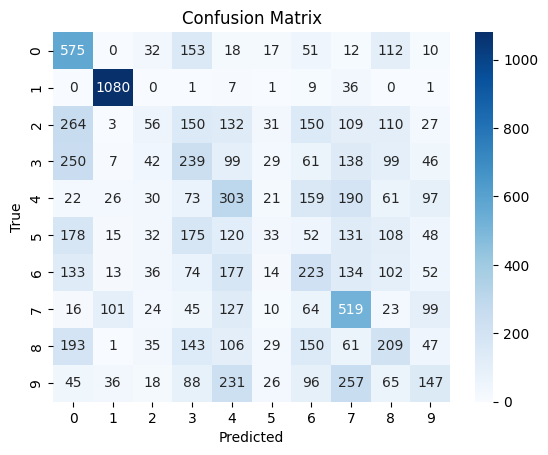

In [43]:
# Enter your code here to visualize the confusion matrix
conf_mat(vis_params['fig_size'])

## Stop Logging

In [44]:
task.close()

# Results and Discussion

All experiments were performed five times with random seeds of [42, 0, 17, 9, 3] (see the table below). The final metrics were calculated as means and standard deviations over five runs. The minimum values of the loss function on validation determined the best checkpoints of the models (see Figure 1).  

!!! Please implement the experiments, fill the table and plot the figure below. !!!


**Table 1.** Results of a series of simulation experiments on the MNIST dataset comparing two approaches: automatic feature extraction using an artificial neural network (ANN), and a hand-designed feature extractor combined with an ANN classifier.

| # | Approach     | Arch.| #train.param. | Seed | Accuracy, \%|
|---|--------------|------|---------------|------|-------------|
| 1 | Img. classif.| MLP  | 109E+3        | 42   | 95.26        |
|   |              |      |               | 0    | 95.12        |
|   |              |      |               | 17   | 94.73        |
|   |              |      |               | 9    | 95.15        |
|   |              |      |               | 3    | 95.22        |
|---|--------------|------|---------------|------|-------------|
| 2 | Tab. classif.| MLP  | 106E+2       | 42   | 34.04        |
|   |              |      |               | 0    | 34.06        |
|   |              |      |               | 17   | 34.35        |
|   |              |      |               | 9    | 33.86        |
|   |              |      |               | 3    | 33.84        |

In [46]:
#Enter your code here to plot the figure using Json data from ClearML
# link to ClearML project
https://app.clear.ml/projects/edae844b1820483eb0d3e3030b2a943d/experiments/compare/scalars;ids=981d79417e06435ea00887bc98d7d769,dfb96509347043edac33a796fd594553,d7e1f87748ae4f1ebd9404ff7de6aa17,bfc1f03c25a0499ca585e1d9f1f8f501,fe63c9905e204366a3920840fe9b46ee,fb605976b3ac46b5b0edf6a46d200751,955e8d87254c4b07ac23dd3b6eb72d24,24b10c357f9f405ea17f8d354cd830c3,c0b91275a6f2464c991744c280f37a0f,114b87e7c0264f9ab5304d5846bdffb4,9c59902645684f72ab31532bd36a74b2,e49d227c93ad4498a6d7ce76b7309821,3441ec9279e24b1abc5658a88651f7a8,2fe6e36007a645a5a847185eee8fc94a?columns=selected&columns=type&columns=name&columns=tags&columns=status&columns=project.name&columns=users&columns=started&columns=last_update&columns=last_iteration&columns=parent.name&order=-last_update&filter=

In [47]:
import numpy as np
appr1 = np.array([95.26, 95.12, 94.73, 95.15, 95.22])
appr2 = np.array([34.04, 34.06, 34.35, 33.86, 33.84])
print(f'approach 1: {appr1.mean()} +- {appr1.std()}')
print(f'approach 2: {appr2.mean()} +- {appr2.std()}')

approach 1: 95.096 +- 0.18958902921846468
approach 2: 34.03 +- 0.18352111595127135


**Figure 1.** Comparison of the validation plots for runs with different model initializations (using different seeds).

Summarizing the result, the first (image processing) and the second (hand-designed features processing) approaches demonstrated accuracy of $ 95.096 \pm 0.19$, and $ 34.03 \pm 0.18$, respectively.

![graphs](/Users/damirnurtdinov/Downloads/ClearML_screen.jpeg)

# Conclusion

As a result of 2 approaches I obtained that ML algorithm is more efficient in feature-extraction than doing it manualy. I also considered different seeds and how they affect prediction accuracy - not so much, but it is important to specify seed! On a figure above you can see the graphs of training loss with different seeds and different approaches. 


# Questions


1. How would you use ClearML to track experiments and compare the performance of different models?
2. What is the role of the random seed in training, and how does it affect reproducibility?
3. What is the purpose of the `prepare_data` method in the `MNISTDataModule`?
4. Why is the dataset split into training, validation, and test sets? What is the role of each set?
5. What does the `transforms.Normalize` function do, and why is it important for training neural networks?
6. Explain the architecture of the MLP model used in this lab. What are the dimensions of the input layer, hidden layers, and output layer? Why is the input size `28 * 28` for the MNIST dataset?
7. What loss function is used in this lab, and why is it suitable for this task? Which optimizer is used, and what is its learning rate?
8. What transformations are applied to the MNIST dataset before training? Why is normalization important, and what values are used for normalization in this lab?
9. What are the geometric features extracted from the MNIST images in the `extract_features` function? Explain each feature briefly.
10. What is the purpose of the `TabularDataModule`? How does it differ from the `MNISTDataModule`?
- The TabularDataModule is designed to convert image data (specifically MNIST images) into tabular data
11. How does the `TabularDataModule` handle the conversion of image data into tabular data?
- The TabularDataModule uses the _extract_features method to convert each image into a feature vector
12. What is the role of the `TensorDataset` class in the `TabularDataModule`?
- TensorDataset class is used to wrap the extracted features and labels into a format that can be easily used with PyTorch's DataLoader for training, validation, and testing.
13. How does the `configure_optimizers` method work, and why is it necessary?
14. What is the significance of the `trainer.fit` and `trainer.test` methods in PyTorch Lightning?
15. What is the purpose of the `self.log` method in PyTorch Lightning? Where can you view the logged metrics?
16. Are the models prone to overfitting? Was this possibility considered and addressed during the modeling process?
17. How is accuracy calculated during the testing phase? What does the confusion matrix represent, and how can it help in evaluating the model's performance?
18. What does the "Top Losses" visualization represent? How can it help in debugging or improving the model?

## Bonus Questions (Optional)
1. What is the purpose of using ClearML in this lab? How does it help in managing machine learning experiments, in general?
2. What are the advantages and disadvantages of using handcrafted features (e.g., geometric features) versus raw pixel values for image classification?
3. How would you adapt the `TabularDataModule` and `TabularModel` for a different dataset (e.g., CIFAR-10)?
4. How would you modify the `TabularDataModule` to include additional features (e.g., histogram of pixel intensities)?
5. What are the challenges of using handcrafted features for more complex datasets (e.g., high-resolution images)?
6. How would you modify the `MLP` architecture to improve its performance on the tabular dataset?
7. What other machine learning models (e.g., decision trees, random forests) could be used for the tabular dataset, and how would you implement them?
8. How would you perform hyperparameter tuning (e.g., learning rate, batch size) for the `TabularModel`?
9. What additional metrics (e.g., precision, recall, F1-score) could you log to evaluate the model’s performance?

